##Import

In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
import pandas as pd
from torch.nn.utils.rnn import pad_sequence

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

##Pre parameter setting

In [2]:
pre_train_accs = []
pre_test_accs =[]
pre_total_losses = []
pre_average_losses = []

full_train_accs = []
full_test_accs =[]
full_total_losses = []
full_average_losses = []

max_len = 512
batch_size = 64
lr = 0.001
n_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load training data

In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/MNLI/train.csv'
data_ori = pd.read_csv(file_path)
data = data_ori
print(data.head())

   promptID   pairID                                            premise  \
0     31193   31193n  Conceptually cream skimming has two basic dime...   
1    101457  101457e  you know during the season and i guess at at y...   
2    134793  134793e  One of our number will carry out your instruct...   
3     37397   37397e  How do you know? All this is their information...   
4     50563   50563n  yeah i tell you what though if you go price so...   

                                premise_binary_parse  \
0  ( ( Conceptually ( cream skimming ) ) ( ( has ...   
1  ( you ( ( know ( during ( ( ( the season ) and...   
2  ( ( One ( of ( our number ) ) ) ( ( will ( ( (...   
3  ( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...   
4  ( yeah ( i ( ( tell you ) ( what ( ( though ( ...   

                                       premise_parse  \
0  (ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...   
1  (ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...   
2  (ROOT (S (NP (NP (CD One)) (PP (IN of) (N

##EDA

In [5]:
print(data.shape)

(392702, 10)


In [6]:
data = data[:10000]  #MNLI 할때 10000개만 보류하라고 하여 10000개만 보류

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   promptID                 10000 non-null  int64 
 1   pairID                   10000 non-null  object
 2   premise                  10000 non-null  object
 3   premise_binary_parse     10000 non-null  object
 4   premise_parse            10000 non-null  object
 5   hypothesis               9998 non-null   object
 6   hypothesis_binary_parse  9998 non-null   object
 7   hypothesis_parse         10000 non-null  object
 8   genre                    10000 non-null  object
 9   label                    10000 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 781.4+ KB
None


In [8]:
print(data.shape)

(10000, 10)


In [9]:
print(data.isnull().sum())

promptID                   0
pairID                     0
premise                    0
premise_binary_parse       0
premise_parse              0
hypothesis                 2
hypothesis_binary_parse    2
hypothesis_parse           0
genre                      0
label                      0
dtype: int64


In [10]:
#data['hypothesis'] = data['hypothesis'].fillna("Unknown")  # null 값을 unknown 으로 보충
#data['hypothesis_binary_parse'] = data['hypothesis_binary_parse'].fillna("Unknown") #  null 값을 unknown 으로 보충
data = data.dropna()  #null 값은 삭제

In [11]:
data = data.drop(columns=['pairID', 'premise_binary_parse', 'premise_parse', 'hypothesis_binary_parse', 'hypothesis_parse'])  # 임무와 무관한 열은 삭제

In [12]:
print(data.isnull().sum())

promptID      0
premise       0
hypothesis    0
genre         0
label         0
dtype: int64


In [13]:
print(data['label'].value_counts())

label
2    3685
0    3412
1    2901
Name: count, dtype: int64


Label 는 3가지 형태로 보이며 분포는 비슷함을 알수가 있습니다.

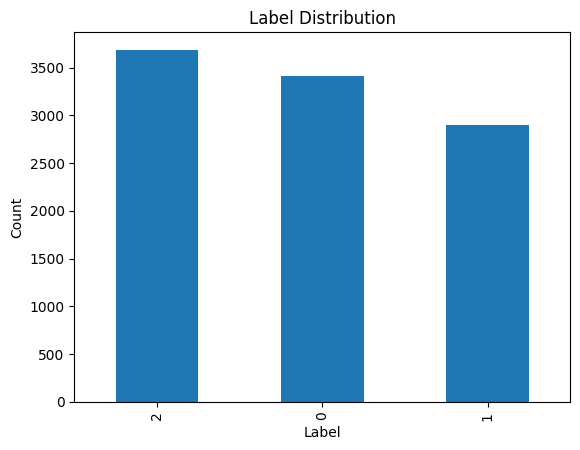

In [14]:
import matplotlib.pyplot as plt

data['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

##[Feedback]
예측값 0,1,2 의 Training label 의 데이터 수량 분포가 데체로 비슷하게 3000 개 좌우로 보입니다.

In [15]:
print(data['premise'])

0       Conceptually cream skimming has two basic dime...
1       you know during the season and i guess at at y...
2       One of our number will carry out your instruct...
3       How do you know? All this is their information...
4       yeah i tell you what though if you go price so...
                              ...                        
9995    Because, despite its monopoly power, Microsoft...
9996                                  'Right,' I mumbled.
9997                                          Thanks dad.
9998                                        which is good
9999    Their breath came in clouds in the cool night ...
Name: premise, Length: 9998, dtype: object


In [ ]:
print(data['hypothesis'])

0       Product and geography are what make cream skim...
1       You lose the things to the following level if ...
2       A member of my team will execute your orders w...
3                       This information belongs to them.
4                The tennis shoes have a range of prices.
                              ...                        
9995    Microsoft owns 60 percent of all computer-rela...
9996                                    'Wrong', I said. 
9997                                       Thanks Obama. 
9998                           I don't think that's great
9999           Their breath was invisible in the hot air.
Name: hypothesis, Length: 9998, dtype: object


##Load test data

In [16]:
file_path = '/content/drive/MyDrive/Colab Notebooks/MNLI/validation_matched.csv'
test_data_ori = pd.read_csv(file_path)
test_data = test_data_ori

In [17]:
test_data = test_data.drop(columns=['pairID', 'premise_binary_parse', 'premise_parse', 'hypothesis_binary_parse', 'hypothesis_parse'])  # 임무와 무관한 열은 삭제
test_data = test_data.dropna()  #null 값은 삭제
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   promptID    9815 non-null   int64 
 1   premise     9815 non-null   object
 2   hypothesis  9815 non-null   object
 3   genre       9815 non-null   object
 4   label       9815 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 383.5+ KB
None


In [18]:
import re
# 텍스트 전처리 함수
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 구두점 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 텍스트 전처리 수행
data['premise'] = data['premise'].apply(preprocess_text)
data['hypothesis'] = data['hypothesis'].apply(preprocess_text)

# 전처리된 데이터 확인
print(data.head())

   promptID                                            premise  \
0     31193  conceptually cream skimming has two basic dime...   
1    101457  you know during the season and i guess at at y...   
2    134793  one of our number will carry out your instruct...   
3     37397  how do you know all this is their information ...   
4     50563  yeah i tell you what though if you go price so...   

                                          hypothesis       genre  label  
0  product and geography are what make cream skim...  government      1  
1  you lose the things to the following level if ...   telephone      0  
2  a member of my team will execute your orders w...     fiction      0  
3                   this information belongs to them     fiction      0  
4            the tennis shoes have a range of prices   telephone      1  


##collate_fn

In [19]:
from transformers import DistilBertTokenizer, logging
import torch

logging.set_verbosity_error()


# 초기화 tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def collate_fn(batch):
    premises = [item["premise"] for item in batch]
    hypotheses = [item["hypothesis"] for item in batch]
    labels = [item["label"] for item in batch]

    #premise & hypothesis 토큰
    inputs = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    #Tensor Lable 전환
    labels = torch.tensor(labels, dtype=torch.long)

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [20]:
print(tokenizer)

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


##DataLoader

In [21]:
from torch.utils.data import Dataset

class MultiNLIDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            "premise": row["premise"],
            "hypothesis": row["hypothesis"],
            "label": row["label"]
        }

In [22]:
#학습 및 테스트 Dataset 생성
train_dataset = MultiNLIDataset(data)
test_dataset = MultiNLIDataset(test_data)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)


##[MyCode]
Tokenizer 의 구체데이터를 직관적으로 검정해봅니다.

In [23]:
first_batch = next(iter(train_loader))
# 배치 출력
# print(first_batch['input_ids'])
tokenizer.convert_ids_to_tokens(first_batch['input_ids'][0])

['[CLS]',
 'all',
 'right',
 'you',
 'too',
 'good',
 'night',
 'then',
 'bye',
 'bye',
 '[SEP]',
 'i',
 'will',
 'talk',
 'to',
 'you',
 'in',
 'the',
 'morning',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [24]:
for data in train_loader:
    print("Input IDs:\n", data["input_ids"])
    print("Input IDs:\n", tokenizer.convert_ids_to_tokens(data["input_ids"][0]))
    print("Attention Mask:\n", data["attention_mask"])
    print("Labels:\n", data["labels"])
    break

Input IDs:
 tensor([[  101,  2065,  1996,  ...,     0,     0,     0],
        [  101,  2061,  2017,  ...,     0,     0,     0],
        [  101,  1998,  2017,  ...,     0,     0,     0],
        ...,
        [  101,  2023, 16625,  ...,     0,     0,     0],
        [  101,  2035,  6401,  ...,     0,     0,     0],
        [  101,  1996, 23564,  ...,     0,     0,     0]])
Input IDs:
 ['[CLS]', 'if', 'the', 'attorney', 'general', 'had', 'ordered', 'up', 'an', 'independent', 'counsel', 'not', 'only', 'would', 'her', 'job', 'have', 'been', 'secure', 'but', 'the', 'new', 'york', 'times', 'and', 'maybe', 'even', 'sen', '[SEP]', 'the', 'attorney', 'general', 'did', 'not', 'order', 'an', 'independent', 'counsel', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

##TextClassifier

In [25]:
import torch
from torch import nn
from transformers import DistilBertModel

class TextClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(TextClassifier, self).__init__()
        # 사전 훈련된 DistilBERT 모델 로딩
        self.bert = DistilBertModel.from_pretrained(pretrained_model_name)
        # 분류 계층 정의
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        # self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # 取 [CLS] token 的向量
        # pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


##Model

In [26]:
from transformers import DistilBertForSequenceClassification, AdamW
from tqdm import tqdm

model = TextClassifier(pretrained_model_name="distilbert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TextClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

## Accuracy function

In [27]:
def accuracy(model, dataloader, device):
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in dataloader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # if isinstance(outputs, dict):
            #     logits = outputs["logits"]
            # else:
            #     logits = outputs

            preds = torch.argmax(outputs, dim=-1)

            total_samples += labels.size(0)
            correct_predictions += (preds == labels).sum().item()

    return correct_predictions / total_samples


In [28]:
for param in model.bert.parameters():
    param.requires_grad = False

##Training mobel

In [29]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Train begin
def train_model(model, data_loader, optimizer, device, epochs, train_type):
    for epoch in range(epochs):
      total_loss = 0.
      model.train()
      for data in train_loader:
        optimizer.zero_grad()

        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)


        preds = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

      print(f"Epoch {epoch:3d} | Train Loss: {total_loss} | Average_loss: {average_loss}" )
      with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader,device)
        test_acc = accuracy(model, test_loader,device)
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
        if train_type == 0:
          pre_train_accs.append(train_acc)
          pre_test_accs.append(test_acc)
          pre_total_losses.append(total_loss)
          pre_average_losses.append(average_loss)
        else:
          full_train_accs.append(train_acc)
          full_test_accs.append(test_acc)
          full_total_losses.append(total_loss)
          full_average_losses.append(average_loss)




##Train start

In [30]:
import warnings
warnings.filterwarnings("ignore")

# Training 시작
train_model(model, train_loader, optimizer, device, n_epochs, train_type=0)


Epoch   0 | Train Loss: 170.11701679229736 | Average_loss: 1.083547877657945
=========> Train acc: 0.468 | Test acc: 0.429
Epoch   1 | Train Loss: 164.71229177713394 | Average_loss: 1.0491228775613626
=========> Train acc: 0.479 | Test acc: 0.431
Epoch   2 | Train Loss: 162.74370485544205 | Average_loss: 1.0365841073595035
=========> Train acc: 0.502 | Test acc: 0.457
Epoch   3 | Train Loss: 160.79198652505875 | Average_loss: 1.0241527804143868
=========> Train acc: 0.484 | Test acc: 0.437
Epoch   4 | Train Loss: 159.8893187046051 | Average_loss: 1.0184033038509879
=========> Train acc: 0.505 | Test acc: 0.462
Epoch   5 | Train Loss: 159.7695951461792 | Average_loss: 1.017640733415154
=========> Train acc: 0.509 | Test acc: 0.465
Epoch   6 | Train Loss: 158.42347884178162 | Average_loss: 1.0090667442151695
=========> Train acc: 0.529 | Test acc: 0.477
Epoch   7 | Train Loss: 158.2196505665779 | Average_loss: 1.007768474946356
=========> Train acc: 0.529 | Test acc: 0.478
Epoch   8 | Tr

##PreTraining Result

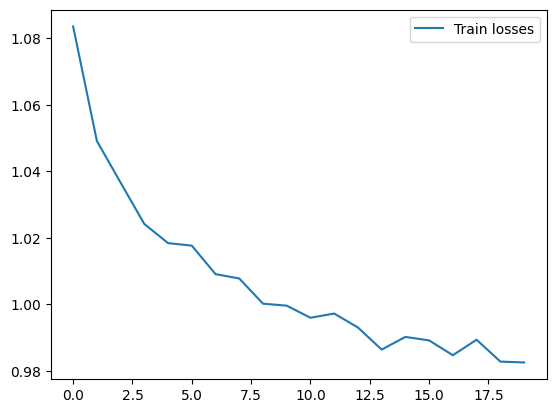

In [31]:
def plot_averagelosses(pre_average_losses, label1='train'):
  x = np.arange(len(pre_average_losses))

  plt.plot(x, pre_average_losses, label=label1)
  plt.legend()
  plt.show()
plot_averagelosses(pre_average_losses, label1='Train losses')

In [32]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

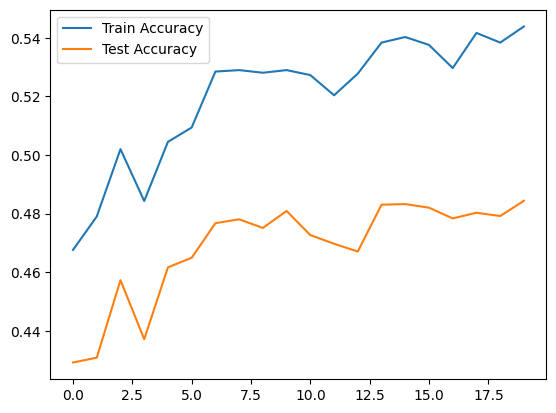

In [33]:
plot_acc(pre_train_accs, pre_test_accs, label1='Train Accuracy', label2='Test Accuracy')

##Start transform full training

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
from math import sqrt
# MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.depth = d_model // n_heads
        self.query = nn.Linear(input_dim, d_model)
        self.key = nn.Linear(input_dim, d_model)
        self.value = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, attention_mask=None):
        batch_size = x.shape[0]

        # Q, K, V 생성
        q = self.query(x).view(batch_size, -1, self.n_heads, self.depth).transpose(1, 2)
        k = self.key(x).view(batch_size, -1, self.n_heads, self.depth).transpose(1, 2)
        v = self.value(x).view(batch_size, -1, self.n_heads, self.depth).transpose(1, 2)

        # 디버깅용 출력
        # Scaled Dot-Product Attention
        score = torch.matmul(q, k.transpose(-2, -1)) / sqrt(self.depth)

        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(2)  # 차원 확장
            score = score.masked_fill(mask == 0, -1e9)

        attention_weights = self.softmax(score)

        context = torch.matmul(attention_weights, v)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.depth)

        output = self.dense(context)
        return output


In [36]:

# TransformerLayer
class TransformerLayer(nn.Module):
    def __init__(self, d_model, n_heads, dff):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x, attention_mask=None):
        attn_output = self.mha(x, attention_mask)
        out1 = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + self.dropout2(ffn_output))
        return out2

In [37]:
# TextClassifier
class Transformer_TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dff):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, n_heads, dff) for _ in range(n_layers)])
        self.classifier = nn.Linear(d_model, 3)  # 3개의 감정분류

    def forward(self, x, attention_mask=None):
        seq_len = x.shape[1]
        x = self.embedding(x) + self.pos_encoding[:, :seq_len, :]
        for layer in self.layers:
            x = layer(x, attention_mask)
        x = x[:, 0, :]
        x = self.classifier(x)
        return x

In [38]:
def full_accuracy(model, dataloader, device):
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in dataloader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # if isinstance(outputs, dict):
            #     logits = outputs["logits"]
            # else:
            #     logits = outputs

            preds = torch.argmax(outputs, dim=-1)

            total_samples += labels.size(0)
            correct_predictions += (preds == labels).sum().item()

    return correct_predictions / total_samples


In [39]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

vocab_size = len(tokenizer)
fulltrain_model = Transformer_TextClassifier(vocab_size, d_model=768, n_layers=10, n_heads=8, dff=256)
fulltrain_model.to(device)


Transformer_TextClassifier(
  (embedding): Embedding(30522, 768)
  (layers): ModuleList(
    (0-9): 10 x TransformerLayer(
      (mha): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=768, bias=True)
      )
      (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=768, out_features=3, bias=True)
)

In [44]:

loss_fn = nn.CrossEntropyLoss()
full_optimizer = Adam(fulltrain_model.parameters(), lr=lr)

# Train begin
# Train begin
def full_train_model(model, data_loader, full_optimizer, device, epochs, train_type):
    model.train()  # 모델을 학습 모드로 전환
    loss_fn = nn.CrossEntropyLoss()  # 손실 함수 정의

    for epoch in range(epochs):
      total_loss = 0.
      model.train()
      for data in train_loader:
        full_optimizer.zero_grad()

        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)


        preds = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(preds, labels)
        loss.backward()
        full_optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

      print(f"Epoch {epoch:3d} | Train Loss: {total_loss} | Average_loss: {average_loss}" )
      with torch.no_grad():
        model.eval()
        train_acc = full_accuracy(model, train_loader,device)
        test_acc = full_accuracy(model, test_loader,device)
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
        full_train_accs.append(train_acc)
        full_test_accs.append(test_acc)
        full_total_losses.append(total_loss)
        full_average_losses.append(average_loss)


In [45]:
full_train_model(fulltrain_model, train_loader, full_optimizer, device, n_epochs, train_type=1)

Epoch   0 | Train Loss: 197.07294011116028 | Average_loss: 1.2552416567589826
=========> Train acc: 0.369 | Test acc: 0.327
Epoch   1 | Train Loss: 174.7140234708786 | Average_loss: 1.112828174973749
=========> Train acc: 0.290 | Test acc: 0.318
Epoch   2 | Train Loss: 174.2525327205658 | Average_loss: 1.1098887434430942
=========> Train acc: 0.369 | Test acc: 0.327
Epoch   3 | Train Loss: 174.05328476428986 | Average_loss: 1.1086196481801902
=========> Train acc: 0.341 | Test acc: 0.354
Epoch   4 | Train Loss: 173.21899819374084 | Average_loss: 1.103305720979241
=========> Train acc: 0.341 | Test acc: 0.354
Epoch   5 | Train Loss: 173.07743155956268 | Average_loss: 1.1024040226723737
=========> Train acc: 0.341 | Test acc: 0.354
Epoch   6 | Train Loss: 172.6279993057251 | Average_loss: 1.0995413968517522
=========> Train acc: 0.369 | Test acc: 0.327
Epoch   7 | Train Loss: 172.8298817873001 | Average_loss: 1.1008272725305739
=========> Train acc: 0.369 | Test acc: 0.327
Epoch   8 | Tr

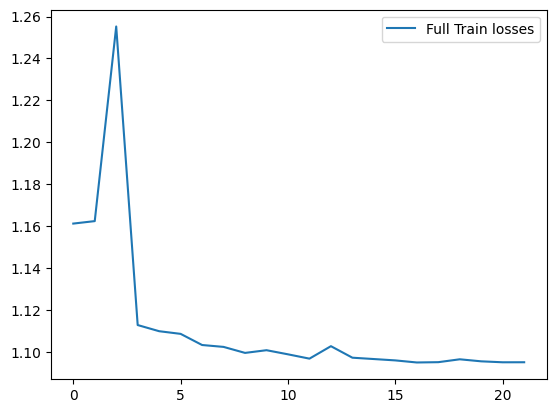

In [46]:
plot_averagelosses(full_average_losses, label1='Full Train losses')

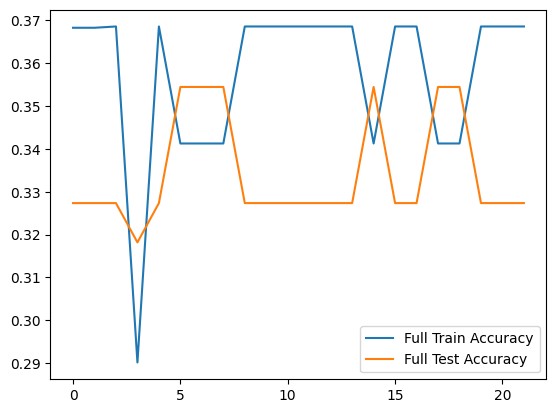

In [47]:
plot_acc(full_train_accs, full_test_accs, label1='Full Train Accuracy', label2='Full Test Accuracy')

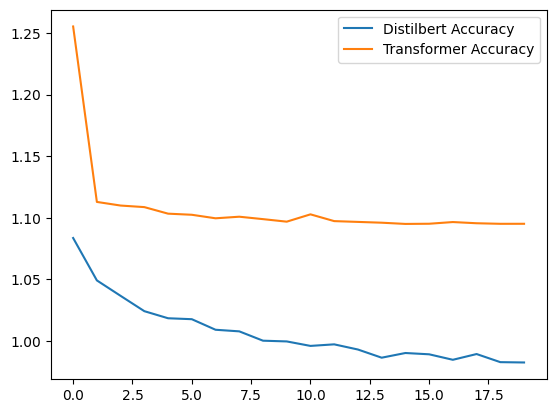

In [64]:
full_train_accs_np = full_train_accs
full_train_accs_np = full_train_accs_np[2:]
full_average_losses_np = full_average_losses
full_average_losses_np = full_average_losses_np[2:]

plot_acc(pre_average_losses, full_average_losses_np, label1='Distilbert Accuracy', label2='Transformer Accuracy')

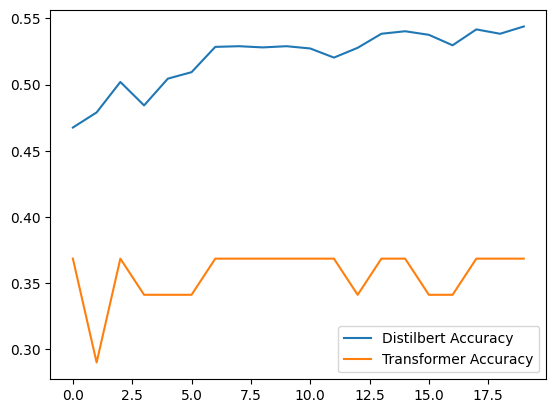

In [65]:
plot_acc(pre_train_accs, full_train_accs_np, label1='Distilbert Accuracy', label2='Transformer Accuracy')

##Conclusion
*   distilbert pretaining 모델을 통한 학습은 속도가 빠르고 정상적인 결과가 보였습니다.
*   distilbert 결과에서는 정확도가 천천히 올라가는 모습이지만 20번의 학습차례에서 55% 가까이의 정확도가 나옵니다.
*   transformer 를 통한 학습은 속도가 느리고, 정확도가 학습기간 정확도 계선되지 못했습니다.
*   distilbert 모델의 성능에서 더욱 빨르고 효과가 더 좋았음을 보여줍니다.



